### 4. Perform LDA on selected topic count

ref: https://radimrehurek.com/gensim/models/ldamodel.html

In [1]:
import time
import ast

start_time = time.time()

In [2]:
import pandas as pd 
import numpy as np
from tqdm import tqdm 
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
import pyLDAvis
import pyLDAvis.gensim_models
from sentence_transformers import SentenceTransformer
import warnings
import pprint
import tensorflow as tf
from lemminflect import getAllInflections

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
vac_article = pd.read_csv('cord19_vaccine_2020_dataset_withBi-Trigram.csv')
vac_article.head()

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  \
0           4             4            4246   
1      393220        483203          736911   
2           6             6            4248   
3      393222        483205          736914   
4      262152        302536          481315   

                                               title  \
0  Synthetic carbohydrate-based vaccines: challen...   
1    Retinal Hemorrhage after SARS-CoV-2 Vaccination   
2  Identification of antigens presented by MHC fo...   
3  Next-Generation Serology by Mass Spectrometry:...   
4  Pre-vaccination Antibody Titers Against Season...   

                                            abstract publish_time  \
0  glycoconjugate vaccines based on bacterial cap...   2020-01-03   
1  to report retinal vein occlusion (rvo) and age...   2021-12-05   
2  mycobacterium tuberculosis (m.tb) is responsib...   2020-01-03   
3  [image: see text] methods of antibody detectio...   2021-12-08   
4  background the prospective assessment of sars-...         2021   

                                     abstract_tokens  \
0  ['glycoconjugate', 'vaccines', 'based', 'bacte...   
1  ['report', 'retinal', 'vein', 'occlusion', 'rv...   
2  ['mycobacterium', 'tuberculosis', 'responsible...   
3  ['image', 'see', 'text', 'methods', 'antibody'...   
4  ['background', 'prospective', 'assessment', 's...   

                                        Lemma_Tokens  \
0  ['glycoconjugate', 'vaccine', 'base', 'bacteri...   
1  ['report', 'retinal', 'vein', 'occlusion', 'rv...   
2  ['mycobacterium', 'tuberculosis', 'responsible...   
3  ['image', 'see', 'text', 'method', 'antibody',...   
4  ['background', 'prospective', 'assessment', 's...   

                                 Phrase_Lemma_Tokens  \
0  ['glycoconjugate', 'vaccine', 'base', 'bacteri...   
1  ['report', 'retinal_vein', 'occlusion', 'rvo',...   
2  ['mycobacterium_tuberculosis', 'responsible', ...   
3  ['image_see', 'text', 'method', 'antibody', 'd...   
4  ['background', 'prospective', 'assessment', 's...   

                         Phrase_Lemma_Tokens_trigram  
0  ['glycoconjugate', 'vaccine', 'base', 'bacteri...  
1  ['report', 'retinal_vein', 'occlusion', 'rvo',...  
2  ['mycobacterium_tuberculosis', 'responsible', ...  
3  ['image_see_text', 'method', 'antibody', 'dete...  
4  ['background', 'prospective', 'assessment', 's...

In [4]:
len(vac_article)

30208

In [5]:
bigram_list_1 = []

for i in range(len(vac_article)):
    bigram_list_1.append(ast.literal_eval(vac_article['Phrase_Lemma_Tokens'][i]))

In [6]:
id2token_vac_article = corpora.Dictionary(bigram_list_1)
corpus_vac_article = [id2token_vac_article.doc2bow(tokens) for tokens in bigram_list_1]

In [7]:
# parameters
NUM_OF_TOPIC = 6

In [8]:
lda_model = LdaMulticore(corpus=corpus_vac_article,
                        id2word=id2token_vac_article,
                        num_topics=NUM_OF_TOPIC,
                        random_state=98,
                        chunksize=200,
                        passes=30,
                        iterations=150,
                        decay=0.7,
                        per_word_topics=True,)

print('Perplexity: ', lda_model.log_perplexity(corpus_vac_article))

Perplexity:  -8.069224631527112


In [9]:
%%time
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus_vac_article, id2token_vac_article)

Wall time: 18.5 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.003118 -0.116873       1        1  20.930614
4      0.066918  0.198525       2        1  20.158674
1      0.046666  0.083749       3        1  18.907231
0      0.102738 -0.153752       4        1  18.078451
5      0.087521 -0.011681       5        1  16.479283
2     -0.306961  0.000033       6        1   5.445746, topic_info=                     Term          Freq         Total Category  logprob  \
86                patient  21875.000000  21875.000000  Default  30.0000   
48                vaccine  71401.000000  71401.000000  Default  29.0000   
108           vaccination  29674.000000  29674.000000  Default  28.0000   
325                  case  10377.000000  10377.000000  Default  27.0000   
37                protein   6717.000000   6717.000000  Default  26.0000   
...                   ...           ...           ...      ...      ...   
72                include    645.387617  13026.692397   Topic6  -5.5629   
2596    acute_respiratory    407.924634   1454.469162   Topic6  -6.0217   
418                 treat    431.639886   2137.929193   Topic6  -5.9652   
503   coronavirus_disease    450.391970   4845.027929   Topic6  -5.9226   
2546                death    423.139402   4371.494989   Topic6  -5.9850   

      loglift  
86    30.0000  
48    29.0000  
108   28.0000  
325   27.0000  
37    26.0000  
...       ...  
72    -0.0946  
2596   1.6390  
418    1.3103  
503    0.5347  
2546   0.5752  

[518 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
11813      5  0.992646  abstract_abridge
11814      5  0.993603   abstract_author
1561       4  0.998636     acceptability
4334       4  0.999624        acceptance
1562       1  0.003798            access
...      ...       ...               ...
110        4  0.308954              year
110        5  0.055649              year
110        6  0.001117              year
6508       6  0.996302           étaient
6509       6  0.995616             était

[1263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 1, 6, 3])

In [10]:
end_time = time.time()

print('Estimate runtime: ', (end_time-start_time)/60, ' minutes.')

Estimate runtime:  5.504336555798848  minutes.


In [11]:
import winsound
duration = 1000  # milliseconds
freq = 440  # Hz
    
winsound.Beep(freq, duration)

In [13]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("model")
lda_model.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [14]:
lda_model.save('lda.model')

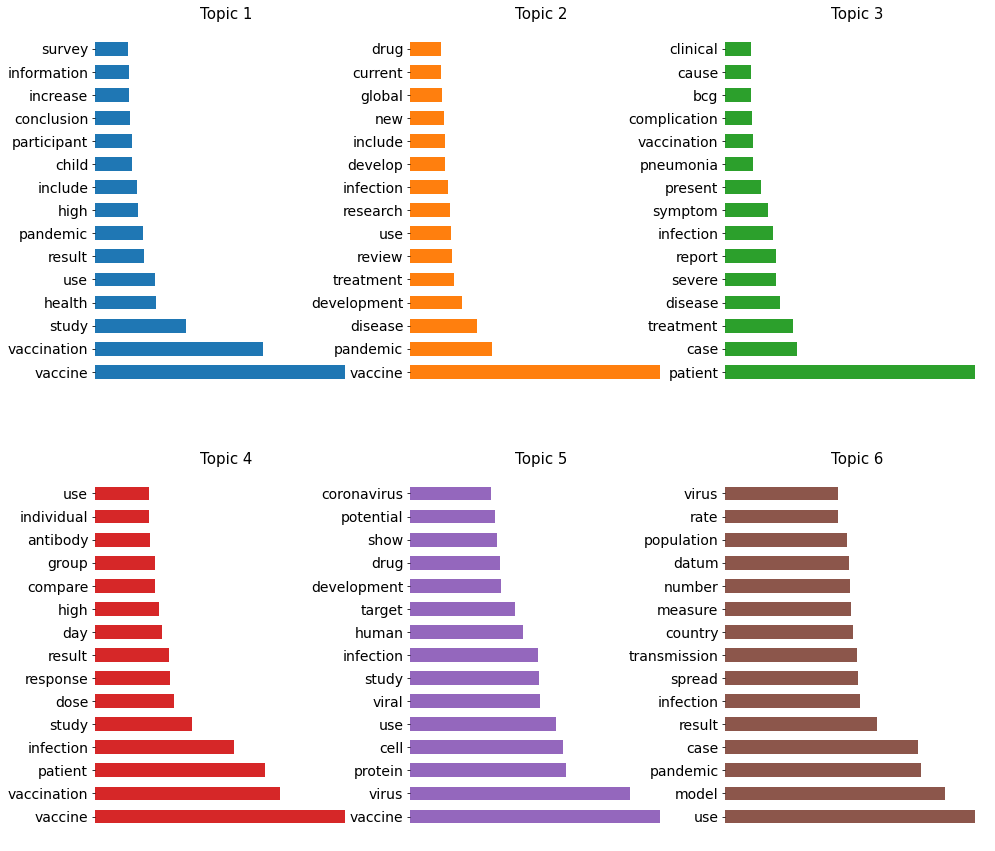

In [15]:
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,15))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    #word_score_dict = dict(topic[1])
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    #fig,ax = plt.subplots(figsize=(7,5))
    ax = fig.add_subplot(2,3,i+1)
    ax.barh(y=words,width=probs,height=0.6,color=sns.color_palette()[i])
    ax.set_yticklabels(labels=words, fontsize=14)
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

In [17]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus_vac_article)):
    document_topic = lda_model.get_document_topics(corpus_vac_article[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

In [18]:
print('len(document_topic_distribution): ', len(document_topic_distribution))
print('document_topic_distribution[4]: ', document_topic_distribution[4])
print('len(num_topic_document): ', len(num_topic_document))
print('topic_frequency: ', topic_frequency)
print(': ')

len(document_topic_distribution):  30208
document_topic_distribution[4]:  [(3, 0.92077607), (4, 0.07459586)]
len(num_topic_document):  30208
topic_frequency:  {0: 13858, 1: 20697, 2: 8963, 3: 15852, 4: 14819, 5: 15485}
: 


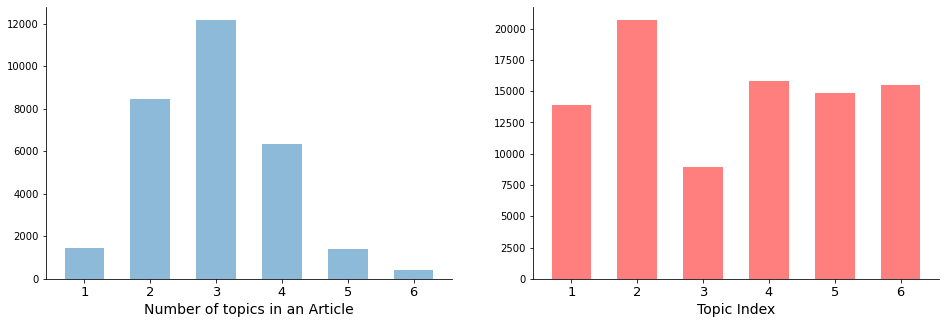

In [19]:
#num_topic_document_counter = collections.Counter(num_topic_document)

#num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
num_topic_document_counter = (pd.DataFrame(num_topic_document)[0]).value_counts(sort=False)

#counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_idx = [str(idx) for idx in num_topic_document_counter.index]

counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6'],fontsize=13)

In [20]:
## Generate document topic matrix
document_topic_matrix = np.zeros((len(corpus_vac_article),6))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix).head()

0         1         2         3         4         5
0  0.0  0.686263  0.000000  0.000000  0.304112  0.000000
1  0.0  0.000000  0.176718  0.815826  0.000000  0.000000
2  0.0  0.034871  0.085443  0.147316  0.729608  0.000000
3  0.0  0.014044  0.000000  0.373295  0.560586  0.047742
4  0.0  0.000000  0.000000  0.920776  0.074596  0.000000

In [21]:
doc_topic_df = pd.DataFrame(document_topic_matrix)
doc_topic_df.to_csv('document_topic_matrix.csv')

In [22]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'vaccine hesitancy', 1: 'biomedical related research', 2: 'vaccination analysis', 3: 'vaccination analysis (recent)', 
                  4: 'researches during the early stage of coronavirus', 5:'corona-related diseases in animals'}
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(vac_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

Loading BokehJS ...